1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [21]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

%matplotlib inline
%precision 8

'%.8f'

There are 2 global minima: 
[[-0.0898  0.7127]
 [ 0.0898 -0.7127]].
The value of the function in the global minimum is -1.0316

For initial value x0=(0,0), the minimum found is [0. 0.], with value 0.0
This probably happens because (0,0) is a saddle point, so if the algorithm is initialized in that point, it converges immediately.


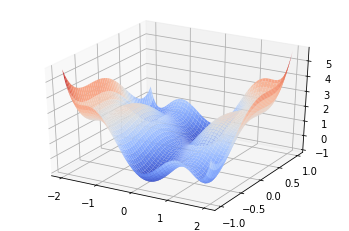

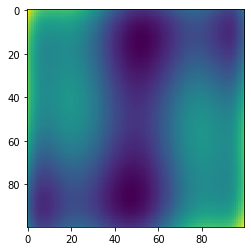

In [5]:
def f(t):
    x = t[0]
    y = t[1]
    return pow(x,2)*(4-2.1*pow(x,2)+pow(x,4)/3)+x*y+pow(y,2)*(4*pow(y,2)-4)

x=np.linspace(-2,2,100)
y=np.linspace(-1,1,100)
X,Y = np.meshgrid(x,y,sparse=True)

minim = []
min_val = []
for i in np.arange(-2,2,0.5):
    for j in np.arange(-1,1,0.5):
        if (i,j) != (0,0):
            loc_min = optimize.minimize(f,x0=(i,j))
            val_found = loc_min.x
            minim.append(np.around(val_found, decimals=4))
            min_val.append(f(np.around(val_found, decimals=4)))
            
minim = np.array(minim)
min_val = np.array(min_val)
minim = [minim[i] for i in range(len(min_val)) if f(minim[i]) == np.min(min_val)]
min_val = np.array(np.around(min_val,decimals=4))

print("There are {} global minima: \n{}.".format(len(np.unique(minim, axis = 0)), np.unique(minim, axis = 0)))
print("The value of the function in the global minimum is {}".format(np.min(min_val)))

loc_min = optimize.minimize(f,x0=(0,0))
val_found = loc_min.x
print("\nFor initial value x0=(0,0), the minimum found is {}, with value {}".format(val_found,f(val_found)))
print("This probably happens because (0,0) is a saddle point, so if the algorithm is initialized in that point, it converges immediately.")

fig = plt.figure()
ax=fig.add_subplot(111,projection='3d')

ax.plot_surface(X,Y,f([X,Y]),cmap = 'coolwarm')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
plt.show()
#y_n = minim[idx][0]*50 +50
#x_n = minim[idx][1]*25 +50

plt.imshow(f([X,Y]))
plt.show()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

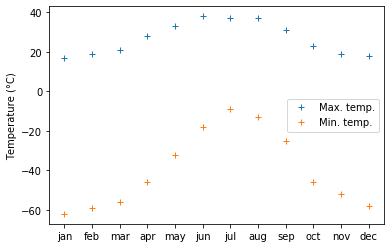

The data look approximately like it could be fitted by gaussians.


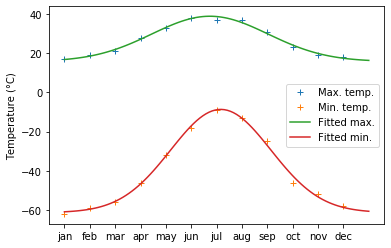

Covariance matrixes:
 MAX
[[ 1.32863961e+00 -1.60410236e-03  7.17535229e-02 -1.08336375e+00]
 [-1.60410236e-03  6.31512717e-03 -1.50059593e-04  1.91632674e-03]
 [ 7.17535229e-02 -1.50059593e-04  1.37716607e-02 -1.20864958e-01]
 [-1.08336375e+00  1.91632674e-03 -1.20864958e-01  1.38428355e+00]]
MIN
[[ 1.32863961e+00 -1.60410236e-03  7.17535229e-02 -1.08336375e+00]
 [-1.60410236e-03  6.31512717e-03 -1.50059593e-04  1.91632674e-03]
 [ 7.17535229e-02 -1.50059593e-04  1.37716607e-02 -1.20864958e-01]
 [-1.08336375e+00  1.91632674e-03 -1.20864958e-01  1.38428355e+00]]

Fit for max temp.
mu = 5.7358 +- 0.0063
sigma = 1.6224 +- 0.0138

Fit for min temp.
mu = 6.1645 +- 0.0022
sigma = 1.3972 +- 0.0029

Correlation coefficient for max temp fit
Rmax = 0.9929147032029073
Correlation coefficient for min temp fit
Rmin = 0.9972984476272073
By looking at the correlation coefficients we can assume the fit to be reasonable.

The time offset for min and max temperatures is not the same within the fit accur

In [22]:
month = ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
max_t = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
min_t = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

plt.plot(month,max_t,label="Max. temp.", ls = "", marker = "+")
plt.plot(month,min_t,label="Min. temp.", ls = "", marker = "+")
plt.ylabel("Temperature (°C)")
plt.legend(loc="center right")
plt.show()

print("The data look approximately like it could be fitted by gaussians.")

def f(x,A,mu,sigma,offset):
    l = offset + A*np.exp(-pow((x-mu)/(2*sigma),2))
    return l

x_data = np.arange(12)
x_plot = np.linspace(0,12,100)

popt_max, pcov_max = optimize.curve_fit(f, x_data, max_t, p0=[10,6,4,20], full_output=False)
popt_min, pcov_min = optimize.curve_fit(f, x_data, min_t, p0=[40,6,2,-60], full_output=False)

plt.plot(month,max_t,label="Max. temp.", ls = "", marker = "+")
plt.plot(month,min_t,label="Min. temp.", ls = "", marker = "+")
plt.ylabel("Temperature (°C)")
plt.plot(x_plot,f(x_plot,popt_max[0],popt_max[1],popt_max[2],popt_max[3]),label="Fitted max.")
plt.plot(x_plot,f(x_plot,popt_min[0],popt_min[1],popt_min[2],popt_min[3]),label="Fitted min.")
plt.legend(loc="center right")
plt.show()


print("Covariance matrixes:\n MAX\n{}\nMIN\n{}".format(pcov_max,pcov_max))
print("\nFit for max temp.\nmu = %.4f +- %.4f\nsigma = %.4f +- %.4f" % (popt_max[1],pcov_max[1,1],popt_max[2],pcov_max[2,2]))
print("\nFit for min temp.\nmu = %.4f +- %.4f\nsigma = %.4f +- %.4f" % (popt_min[1],pcov_min[1,1],popt_min[2],pcov_min[2,2]))

fitted_y = np.array([f(x,popt_max[0],popt_max[1],popt_max[2],popt_max[3]) for x in x_data])
Rmax = np.sqrt(1 - (np.sum(pow(max_t - fitted_y,2)))/(np.sum(pow(np.mean(max_t) - max_t,2))))
print("\nCorrelation coefficient for max temp fit\nRmax =",Rmax)
fitted_y1 = np.array([f(x,popt_min[0],popt_min[1],popt_min[2],popt_min[3]) for x in x_data])
Rmin = np.sqrt(1 - (np.sum(pow(min_t - fitted_y1,2)))/(np.sum(pow(np.mean(min_t) - min_t,2))))
print("Correlation coefficient for min temp fit\nRmin =",Rmin)

print("By looking at the correlation coefficients we can assume the fit to be reasonable.")
print("\nThe time offset for min and max temperatures is not the same within the fit accuracy.")

In [17]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

--2021-12-26 12:58:58--  https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6025:18::a27d:4512
Connessione a www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/3uqleyc3wyz52tr/residuals_261.pkl [segue]
--2021-12-26 12:58:58--  https://www.dropbox.com/s/raw/3uqleyc3wyz52tr/residuals_261.pkl
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc5383a3f1cadfe4c397ce85a012.dl.dropboxusercontent.com/cd/0/inline/Bcll4rkQS4s2iAsGdUS3H51q64g0WSoEdulX7AnPRDvuiGsaPBJNXlQbHP4T_IpIjuayjuXP-1AjKgznsdwn5WFrZuq1-C-3hZkSwQ-4D6junMWCSMRt1jDJPZtWEbO7_SzGT0PTAwXQN_HCPC1WRkcM/file# [segue]
--2021-12-26 12:58:58--  https://uc5383a3f1cadfe4c397ce85a012.dl.dropboxusercontent.com/cd/0/inline/Bcll4rkQS4s2iAsGdUS3H51q64g0WSoEdulX7AnPRDvuiG

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

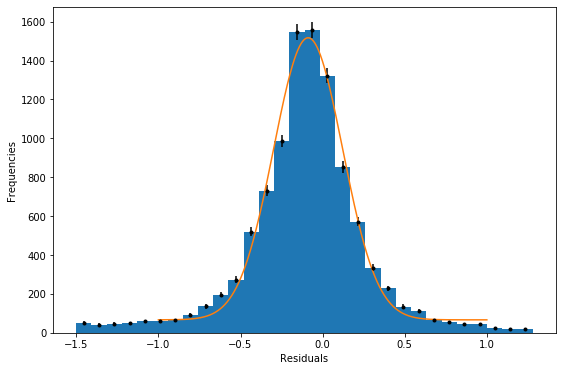

Chi2 = 555.37
p value = 0.0

The goodness of fit test does not result in a satisfactory p-value, meaning that the gaussian function is probably inadequate for fitting the data.


,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [28]:
datafile = np.load("residuals_261.pkl", allow_pickle = True)
data = datafile.tolist()
dataf = pd.DataFrame(data)

plt.figure(figsize=(9, 6))

x = dataf["residuals"]
x = x[x< 1.3]
x = x[x>-1.5]
b = 30
bin_counts, bin_edges, patches = plt.hist(x,bins=b)
plt.ylabel("Frequencies")
plt.xlabel("Residuals")
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
y_error = (np.sqrt(bin_counts))
plt.errorbar(x=bin_centres, y=bin_counts,
             yerr=y_error, fmt='.k')

def f(x,A,mu,sigma,c):
    return c + A*np.exp(-pow((x-mu)/(sigma),2)/2)
    
x_plot = np.linspace(int(min(x)),int(max(x)),1000)

popt, pcov = optimize.curve_fit(f, bin_centres, bin_counts, full_output=False)
plt.plot(x_plot,f(x_plot,popt[0],popt[1],popt[2],popt[3]),label="Fitting curve")
plt.show()

chi2 = np.sum(pow((bin_counts - f(bin_centres,popt[0],popt[1],popt[2],popt[3]))/y_error,2))
ndof = b - 1
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("Chi2 = %.2f" % chi2)
print("p value = {}".format(pvalue))
print("\nThe goodness of fit test does not result in a satisfactory p-value, meaning that the gaussian function\
 is probably inadequate for fitting the data.")

dataf

In [183]:
! wget https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt

--2021-12-27 13:37:11--  https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6025:18::a27d:4512
Connessione a www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt [segue]
--2021-12-27 13:37:12--  https://www.dropbox.com/s/raw/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc461c92bac3731e43b0919565d6.dl.dropboxusercontent.com/cd/0/inline/BcoFdVrOXnFr1btiiSouGNZKsTDTk7z-QBPiOW3IMt9zirPJN0j5bfeBcWMAr473RCJrMcc4RRfP5NWtFVRBT15ybjaFy-UQzGMlJF60Bff10_GWKKakjDNO_TMHgK-pTi4KAaXigd9kk7QvW02UP-9k/file# [segue]
--2021-12-27 13:37:12--  https://uc461c92bac3731e43b0919565d6.

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

The best parameters of the fit are:
a = 9.99 +- 0.03
b = 2.9082 +- 0.0003
c = 9.38 +- 0.02

The average temperature in Munich is given by the parameter c, so  around 9.38°C
The avarage daily temperature for the hottest time of the year is around 19.37°C (c+a)
The avarage daily temperature for the coldest time of the year is around 0.60°C (c-a)
The b parameter is the phase of the cosine function and its meaning is to 'align' the maxima of the function with the actual hottest period of the year, and consequently the minima with the coldest, obviously with a yearly periodicity.


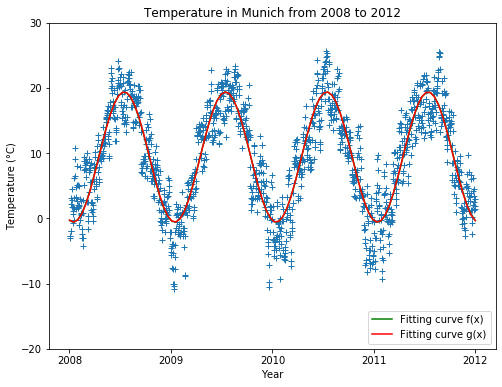


The RSS for f(x) is: 34359.8586
The RSS for g(x) is: 34352.7941

Comparison between the two functions:
CL: 0.584 , additional parameter necessary: NO


,time,temperature
0,1995.00274,0.944444
1,1995.00548,-1.611110
2,1995.00821,-3.555560
3,1995.01095,-9.833330
4,1995.01369,-10.222200
...,...,...
6674,2013.27379,7.333330
6675,2013.27652,10.000000
6676,2013.27926,10.555600
6677,2013.28200,8.944440


In [25]:
df = pd.DataFrame(pd.read_csv("munich_temperatures_average_with_bad_data.txt", header=None,  delimiter=" ", names = ["time","temperature"]))

def f(t,a,b,c):
    return a*np.cos(2*np.pi*t + b) + c

def g(t,a,b,c,d):
    return a*np.cos(2*np.pi*b*t + c) + d

gridsize = (1, 1)
fig = plt.figure(figsize=(8, 6))
hs = plt.subplot2grid(gridsize, (0, 0))
hs.xaxis.set_major_locator(plt.MultipleLocator(1))

x_data = np.array([val for val in df["time"] if val <= 2012 and val > 2008])
dfy = df[df["time"] >= 2008]
y_data = np.array(dfy["temperature"][dfy["time"] <= 2012])
plt.plot(x_data,y_data, marker = "+", ls = "")
x_plot = np.linspace(2008,2012,100)
popt, pcov = optimize.curve_fit(f, x_data, y_data, p0 = [10, 3, 10], full_output=False)
plt.plot(x_plot,f(x_plot,popt[0],popt[1],popt[2]),label="Fitting curve f(x)",color = "green")
plt.ylim((-20,30))

print("The best parameters of the fit are:\na = %.2f +- %.2f\nb = %.4f +- %.4f\nc\
 = %.2f +- %.2f" % (popt[0], pcov[0,0], popt[1], pcov[1,1], popt[2], pcov[2,2]))
print("\nThe average temperature in Munich is given by the parameter c, so  around %.2f°C" % (popt[2]))
print("The avarage daily temperature for the hottest time of the year is around %.2f°C (c+a)" % (popt[0] + popt[2]))
print("The avarage daily temperature for the coldest time of the year is around %.2f°C (c-a)" % (popt[0] - popt[2]))
print("The b parameter is the phase of the cosine function and its meaning is to 'align' the maxima of the\
 function with the actual hottest period of the year, and consequently the minima with the coldest,\
 obviously with a yearly periodicity.")

popt1, pcov1 = optimize.curve_fit(g, x_data, y_data, full_output=False)
plt.plot(x_plot,g(x_plot,popt1[0],popt1[1],popt1[2], popt1[3]),label="Fitting curve g(x)",color = "red")
plt.legend(loc = "lower right")
plt.title("Temperature in Munich from 2008 to 2012")
plt.ylabel("Temperature (°C)")
plt.xlabel("Year")
plt.show()

def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

RSSf = 0
RSSg = 0
for i in range(len(x_data)):
    RSSf += pow((y_data[i] - f(x_data[i],popt[0],popt[1],popt[2])),2)
    RSSg += pow((y_data[i] - g(x_data[i],popt1[0],popt1[1],popt1[2],popt1[3])),2)
print("\nThe RSS for f(x) is: %.4f" % (RSSf))
print("The RSS for g(x) is: %.4f" % (RSSg))
ndoff = 3 - 1
ndofg = 4 - 1

print("\nComparison between the two functions:")
comp = Ftest(RSSf, RSSg, ndoff, ndofg, len(x_data), verbose=True)

df